# TESTING ENVIRONMENT

In [1]:
import torch

# torch version
print("torch version:", torch.__version__)

# cudnn version
print("cudnn version:", torch.backends.cudnn.version())

torch version: 2.0.1+cu117
cudnn version: 8500


In [2]:
#cuda version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# INSTALLATION

In [3]:
!python -m pip install -q aura-sr diffusers controlnet_aux

# GLOBAL IMPORTS

In [ ]:
from PIL import Image

# 1. ENHANCE IMAGE

> **Tested on Colab T4 GPU**

In [ ]:
from modules.enhancer import Enhancer

In [6]:
enhancer = Enhancer(config_path="./configs/enhancer.yaml")

> LOAD CONFIG...
> LOAD DEVICE...
>> Using GPU...
> LOAD MODEL...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
enhanced_image = enhancer.enhance(image_path="./assets/0_sample_input.png", resized_size=(1024,1024))

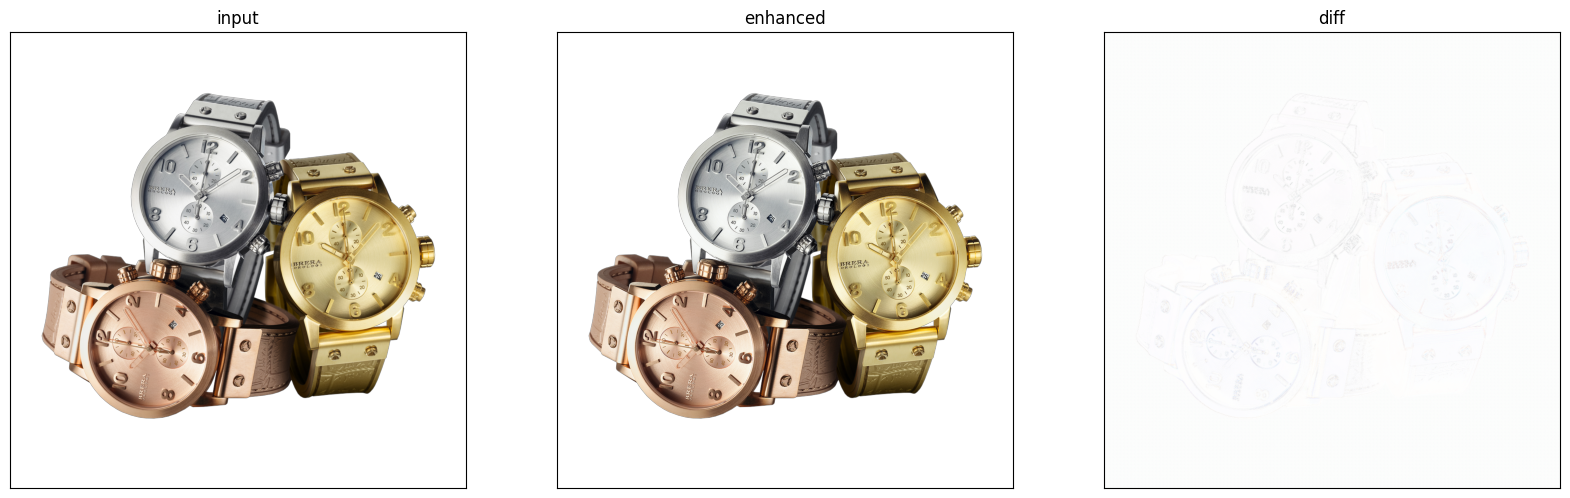

In [8]:
enhancer.plot()

In [9]:
enhanced_image.save("./assets/1_enhanced_image.png")

In [9]:
enhancer.clear_memory()

> CLEAR MEMORY...


# 2. CREATE SCENE

> **Tested on Colab T4 GPU**

In [ ]:
from modules.scene_generator import SceneGenerator

In [11]:
scene_generator = SceneGenerator("./configs/scene_generator.yaml")

> LOAD CONFIG...
> LOAD DEVICE...
>> Using GPU...


In [ ]:
generated_scene = scene_generator.create_scene(
    image_path="./assets/1_enhanced_image.png",
    prompt="A sleek, modern ad showcasing luxury watches in a futuristic cityscape",
    negative_prompt="bad quality, worst quality, low resolution",
    seed=42,
    resized_size=(1024,1024)
)

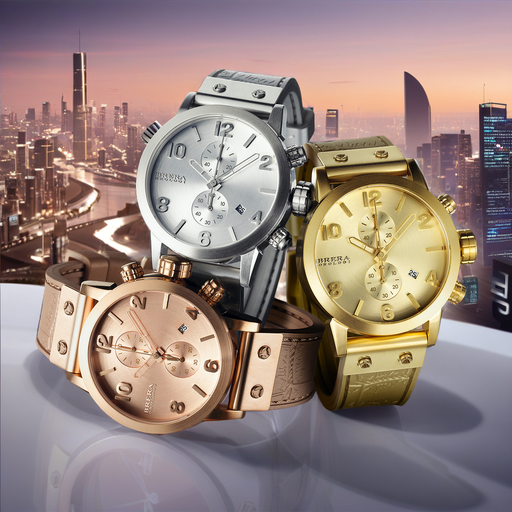

In [ ]:
generated_scene.resize((512,512), Image.LANCZOS)

In [ ]:
generated_scene.save("./assets/2_generated_scene.png")

# 3. GENERATE VIDEO

> **Tested on Colab A100 GPU**

In [7]:
!git clone https://github.com/Stability-AI/generative-models.git
!mv generative-models generative_models

Cloning into 'generative-models'...
remote: Enumerating objects: 1064, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1064 (delta 55), reused 94 (delta 47), pack-reused 941 (from 1)
Receiving objects: 100% (1064/1064), 53.61 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (545/545), done.


In [ ]:
!python -m pip install -q -r generative_models/requirements/pt2.txt

> **Restart kernel after installing**

In [9]:
!mv modules/video_generator.py generative_models/

In [6]:
%cd generative_models

/content/generative_models


In [7]:
from video_generator import VideoGenerator

In [8]:
video_generator = VideoGenerator("/content/configs/video_generator.yaml")

> LOAD CONFIG...
> LOAD DEVICE...
>> Using GPU...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


svd_xt_1_1.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

File downloaded.


In [9]:
generated_scene = Image.open("/content/assets/2_generated_scene.png").resize((576,576), Image.LANCZOS)

In [10]:
generated_video = video_generator.generate_video(
    image=generated_scene,
    seed=42,
    fps_id=6,
    motion_bucket_id=127,
    cond_aug=0.02,
)

VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Initialized embedder #0: FrozenOpenCLIPImagePredictionEmbedder with 683800065 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: VideoPredictionEmbedderWithEncoder with 83653863 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
Restored from checkpoints/svd_xt_1_1.safetensors with 0 missing and 0 unexpected keys


100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 144MiB/s]


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


> CLEAR MEMORY...


In [17]:
import imageio
imageio.mimwrite("/content/assets/3_generated_video.mp4", generated_video)

In [18]:
from IPython.display import HTML
from base64 import b64encode

video_path = '/content/assets/3_generated_video.mp4'
mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f'''
<video width="640" height="480" controls loop autoplay>
      <source src="{data_url}" type="video/mp4">
</video>
''')